In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/Users/rubenbroekx/Documents/Projects/radix-co2-reduction


# Cover Crop Detection - Random Forest

In [2]:
import json
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path
from collections import Counter
from typing import List, Any, Tuple, Dict, Optional
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC

from src.radix_co2_reduction.data import load_pixel_data, dma, datetime_to_int, BANDS, load_data, get_year

# Load Data

Load in all data used for the unsupervised classification.

In [3]:
# Root data folder
DATA = Path.home() / 'data/agoro/2021-05-10'

In [4]:
# Fetch field-IDs
all_ids = glob(str(DATA / '*/ndti.png'))
all_ids = [int(i.split('/')[-2]) for i in all_ids]

## Features

Perform feature extraction on the received data.

In [6]:
def extract_vector(field_id:int, band:str='NDVI') -> Optional[np.ndarray]:
    """Extract the combined vector of (down) sampled NDVI values of all field pixel values (averaged)."""
    assert band in BANDS

    # Load the data, if exists
    data, _ = load_pixel_data(
        DATA / f'{field_id}', 
        downsample=10, 
        window=30,
        remove_neg=True,  # Removes noisy samples
        remove_zero=False,  # Only complete vectors
    )
    if not data: return None
    data = np.asarray(data)
    data_comb = np.nan_to_num(np.nanmedian(np.where(data == 0, np.nan, data), axis=0))
    return data_comb[BANDS.index(band)]

def plot_time_series(field_id:int, band:str='NDVI'):
    """Plot the given time-series."""
    vector = extract_vector(field_id, band=band)
    if vector is None: 
        print(f"No data found for {field_id}")
        return
    plt.figure(figsize=(len(vector)//3, 3))
    plt.plot(vector, color='blue')

    # Plot the scattered data
    dates, raw_values = zip(*sorted(load_data(DATA / f'{field_id}').items()))
    start_idx = datetime_to_int(f"{get_year(DATA / f'{field_id}') - 1}-11-01")
    date_idx = [(datetime_to_int(d) - start_idx) / 10 for d in dates]
    for date, raw_value in zip(date_idx, raw_values):
        val = [v for v in raw_value[band] if v is not None]
        plt.scatter(date, sum(val)/len(val), color='red', linewidths=.2)

    # Add general plot attributes
    plt.title(f"{field_id} - {band}")
    plt.xlabel("Time (old to new)")
    plt.xticks([])
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

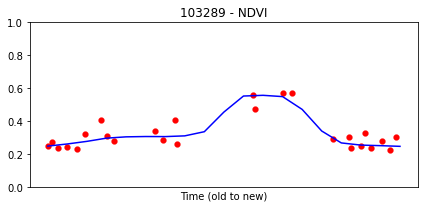

In [7]:
# Show example
FIELD_ID = 103289
plot_time_series(FIELD_ID)

In [8]:
# Extract all the vectors
vectors, vector_ids = [], []
for field_id in tqdm(all_ids):
    field_vector = extract_vector(field_id)
    if field_vector is not None:
        vectors.append(field_vector)
        vector_ids.append(field_id)
print(f"Loaded in a total of {len(vectors)} vectors")

  1%|          | 5/966 [00:02<08:37,  1.86it/s]/Users/rubenbroekx/opt/miniconda3/envs/radix-co2-reduction-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
  4%|▎         | 35/966 [00:15<06:34,  2.36it/s]/Users/rubenbroekx/opt/miniconda3/envs/radix-co2-reduction-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|██████████| 966/966 [07:10<00:00,  2.24it/s]

Loaded in a total of 958 vectors


In [9]:
def get_feature(vector:List[float]) -> List[float]:
    """
    Get the bucket feature corresponding the field-ID.
    
    This feature calculates for each bucket the min, mean, max, std, and slope-progress.
    """
    # Calculate slopes
    slopes = [
        vector[i+1]-vector[i] if (vector[i+1] != 0) and (vector[i] != 0) else 0
        for i in range(len(vector)-1)
    ]
    
    # Remove zero values
    values = [v for v in vector if v != 0]
    slopes = [s for s in slopes if s != 0]
    
    # Create features
    return [
        min(values),
        sum(values)/len(values),
        max(values),
        min(slopes),
        sum(slopes)/len([s for s in slopes if s != 0]),
        max(slopes),
    ]
#     features = []
#     for i in range(len(vector)-1):
#         values.append(vector)
#         val = vector[i]
#         slope = vector[i+1]-vector[i] if (vector[i+1] != 0) and (vector[i] != 0) else 0
#         features += [val, slope]
#     features.append(vector[-1])
#     return features

In [10]:
get_feature(vectors[0])

[0.21388084781401367,
 0.23204295641108352,
 0.2757930886922496,
 -0.01718789538703741,
 -0.0026115106756517464,
 0.00502279252927304]

In [11]:
# Create features for all the fields
features = [get_feature(v) for v in vectors]

## HDBScan

Perform unsupervised clustering on the created features using [HDBScan](https://hdbscan.readthedocs.io/en/latest/index.html). For every cluster found by the HDBScan, evaluate a few on whether or not they contain cover crop.

In [12]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,  # min #samples / cluster
    min_samples=2,  # How conservative to cluster
)
clusterer.fit(features)

print(f"Number of clusters found: {clusterer.labels_.max()+1}")
for c_id in set(clusterer.labels_):
    print(f" - Cluster {c_id}: {sum(clusterer.labels_ == c_id)}")
print(f"Number of items clustered: {(clusterer.labels_ != -1).sum()}")
print(f"Number of items labeled as noise: {(clusterer.labels_ == -1).sum()}")

Number of clusters found: 10
 - Cluster 0: 6
 - Cluster 1: 10
 - Cluster 2: 5
 - Cluster 3: 5
 - Cluster 4: 6
 - Cluster 5: 19
 - Cluster 6: 13
 - Cluster 7: 5
 - Cluster 8: 10
 - Cluster 9: 682
 - Cluster -1: 197
Number of items clustered: 761
Number of items labeled as noise: 197


<AxesSubplot:ylabel='$\\lambda$ value'>

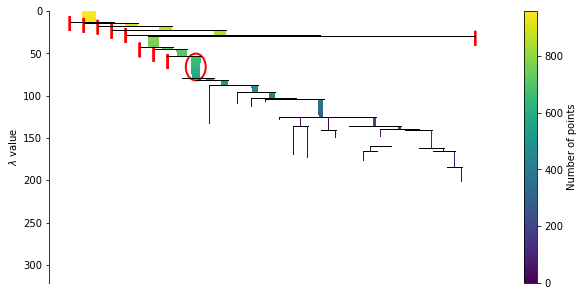

In [13]:
plt.figure(figsize=(10,5))
clusterer.condensed_tree_.plot(
    select_clusters=True,
)

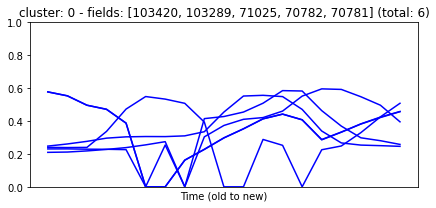

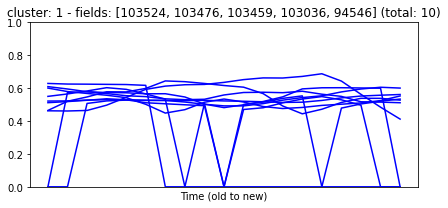

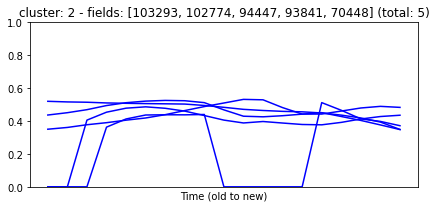

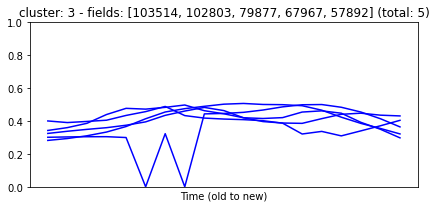

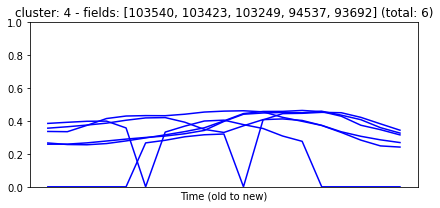

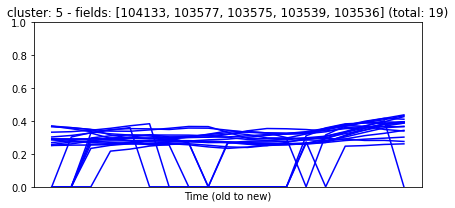

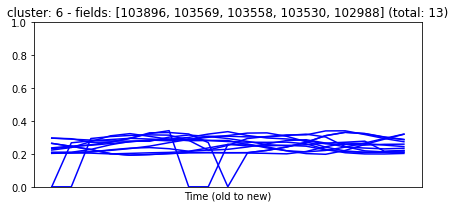

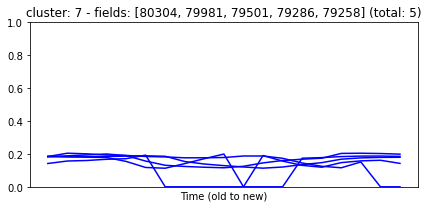

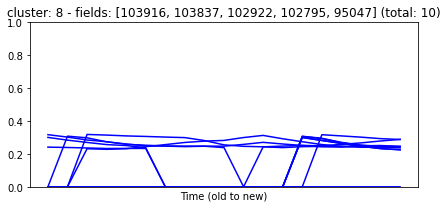

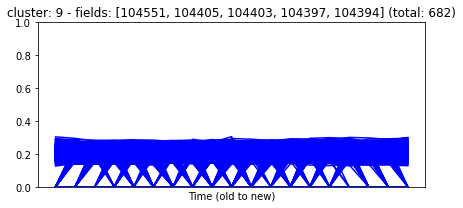

In [14]:
# Plot a time-series of each cluster
def plot_time_series_cluster(cluster_id:int):
    """Plot the given time-series."""
    cluster_vectors = [v for label,v in zip(clusterer.labels_,vectors) if label == cluster_id]
    cluster_ids = {i for label,i in zip(clusterer.labels_,vector_ids) if label == cluster_id}
    plt.figure(figsize=(len(cluster_vectors[0])//3, 3))
    for vector in cluster_vectors:
        plt.plot(vector, color='blue')

    # Add general plot attributes
    plt.title(f"cluster: {cluster_id} - fields: {sorted(cluster_ids, reverse=True)[:5]} (total: {len(cluster_ids)})")
    plt.xlabel("Time (old to new)")
    plt.xticks([])
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
for c_id in set(clusterer.labels_) - {-1}:
    plot_time_series_cluster(c_id)

Results from the clustering:
 - **Cover crop:** 94546, 103524, 103476, 103293, 103036, 103154, 103038, 103423, 103256, 103249, 103536, 94114, 103688, 57901, 103071, 94513, 103639, 102834, 102784, 93836, 68001, 102919, 103424, 104133, 94523, 94625
 - **Non-cover crop:** 103698, 103575, 103810, 104403, 104397, 104394, 104353, 104312, 79482, 68364, 103408, 104551, 104354
 - **Uncertain:** 94537, 103540, 103539, 93981, 94538, 68129, 94066, 103478

Remarks:
 - Main difference between "when" --> early (around December/January) or late (around March, but still before the said 'planting date')

In [15]:
# Classify clusters using annotated Beck's data
beck = pd.read_csv(Path.cwd() / 'data/beck_corrected.csv')
print(f"Annotated total of {(~beck.cover_crop.isna()).sum()} fields")

Annotated total of 69 fields


In [16]:
clusters = [None,] * len(vector_ids)

def assign_cluster(c_id:int):
    ids = sorted({i for label,i in zip(clusterer.labels_,vector_ids) if label == c_id})
    labels = [beck[beck.id == i].iloc[0].cover_crop for i in ids]
    if (True in labels) and (False in labels):
        print(f"Conflicting cluster {c_id} with:")
        data = [(i,l) for i,l in zip(ids, labels) if isinstance(l,bool)]
        print(f" - Data (ID, label): {list(reversed(data))}")
        return
    if (True not in labels) and (False not in labels):
        print(f"No classified samples in cluster {c_id} with:")
        print(f" - IDs: {list(reversed(ids))}")
        return
        
    label = True if True in labels else False
    for i in ids: clusters[vector_ids.index(i)] = label

In [17]:
# Assign labels to all clustered data
for c_id in set(clusterer.labels_) - {-1}:
    assign_cluster(c_id)
    
# Assign individual data (for unclustered items)
for field_id, cover_crop in zip(beck.id, beck.cover_crop):
    if isinstance(cover_crop, bool):
        clusters[vector_ids.index(field_id)] = cover_crop

print("\nCluster-overview")
print(f" -     Clustered as cover-crop: {sum(c == True for c in clusters)}")
print(f" - Clustered as non-cover-crop: {sum(c == False for c in clusters)}")
print(f" -                 Unclustered: {sum(c is None for c in clusters)}")

Conflicting cluster 6 with:
 - Data (ID, label): [(103569, False), (102834, True), (102777, True), (93741, False), (79391, True)]

Cluster-overview
 -     Clustered as cover-crop: 79
 - Clustered as non-cover-crop: 706
 -                 Unclustered: 173


## K-Nearest Neighbours

Perform [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on the remaining (unclustered) samples. Check the distance to nearest neighbour, manually evaluate those that are very distant from a known neighbour.

In [18]:
# Collect all labeled data
features_labeled, labels_labeled = zip(*[(f,l) for f, l in zip(features, clusters) if l is not None])
print(f"Number of labeled data: {len(labels_labeled)}")

Number of labeled data: 785


In [19]:
# Fit a nearest neighbour algorithm
neighbours = KNeighborsClassifier(
    n_neighbors=1,
).fit(features_labeled, labels_labeled)

In [20]:
# Classify all samples
labels_pred = neighbours.predict(features)
assert len(labels_pred) == len(features)
assert None not in labels_pred

print(f"Final distribution:")
print(f" -    With cover-crop: {sum(labels_pred)}")
print(f" - Without cover-crop: {sum(~labels_pred)}")

Final distribution:
 -    With cover-crop: 163
 - Without cover-crop: 795


In [21]:
# Investigate "far away" samples
distances = list(neighbours.kneighbors(features, n_neighbors=1, return_distance=True)) + [vector_ids,]
neighbour_distances = [(a[0],b[0],c) for a,b,c in zip(*distances)]

print(f"Furthest samples:")
for a,b,c in sorted(neighbour_distances, reverse=True):
    if a < .2: break
    print(f" - Field {c} with distance {a} to neighbour {vector_ids[b]}")

Furthest samples:


## TensorBoard

Create a TensorBoard visualisation to show the clustering-result.

In [22]:
import tensorflow as tf
from tensorboard.plugins import projector

# Visualise using tensorboard
projector_path = Path.cwd() / f'projector/cover_crop'
projector_path.mkdir(exist_ok=True, parents=True)

# Get data embeddings and predict all the clusters
embeddings = features
labels = labels_pred
ids = vector_ids
assert len(embeddings) == len(labels) == len(ids)

# Save Labels separately on a line-by-line manner.
with open(projector_path / f'metadata.tsv', "w") as f:
    joint = [f'{i}\t{l}' for i,l in zip(ids,labels)]
    f.write('ID\tLabel\n' + '\n'.join(joint) + '\n')

# Save the weights we want to analyse as a variable. Note that the first value represents any unknown word,
# which is not in the metadata, so we will remove that value.
weights = tf.Variable(embeddings)

# Create a checkpoint from embedding, the filename and key are name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(projector_path / f"embedding.ckpt")

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = f'metadata.tsv'
projector.visualize_embeddings(projector_path, config)

print("Run tensorboard in terminal:")
print(f"tensorboard --logdir {projector_path}")

print("\nOr run tensorboard in notebook:")
print(f"%load_ext tensorboard")
print(f"%tensorboard --logdir {projector_path}")

Run tensorboard in terminal:
tensorboard --logdir /Users/rubenbroekx/Documents/Projects/radix-co2-reduction/projector/cover_crop

Or run tensorboard in notebook:
%load_ext tensorboard
%tensorboard --logdir /Users/rubenbroekx/Documents/Projects/radix-co2-reduction/projector/cover_crop


## Train SVM

To distinguish between the two classes, we train a SVM.

In [23]:
clf = SVC(
    random_state=42,
)

# Balance dataset
sm = RandomOverSampler(random_state=42)
features_svm, labels_svm = sm.fit_resample(features, labels_pred)

# Train using all (incl. K-NN approximated) the samples
clf.fit(
    features_svm,
    labels_svm,
)

# Evaluate on same labels (try to identify wrongly classified samples)
pred = clf.predict(
    features,
)
c = Counter()
for t,p,i in zip(labels_pred, pred, vector_ids):
    c[t==p] += 1
    if t != p:
        print(f"Wrongly classified: {i} (true: {t}, pred: {p})")
print(f"\nGlobal accuracy: {100*c[True]/sum(c.values()):.2f}%")

Wrongly classified: 94538 (true: False, pred: True)
Wrongly classified: 93741 (true: False, pred: True)
Wrongly classified: 103446 (true: False, pred: True)
Wrongly classified: 103558 (true: False, pred: True)
Wrongly classified: 103569 (true: False, pred: True)
Wrongly classified: 93895 (true: False, pred: True)
Wrongly classified: 95360 (true: False, pred: True)
Wrongly classified: 93844 (true: False, pred: True)
Wrongly classified: 79351 (true: False, pred: True)
Wrongly classified: 103295 (true: True, pred: False)
Wrongly classified: 93796 (true: False, pred: True)
Wrongly classified: 79857 (true: False, pred: True)
Wrongly classified: 94078 (true: False, pred: True)
Wrongly classified: 79923 (true: False, pred: True)
Wrongly classified: 68009 (true: False, pred: True)
Wrongly classified: 71598 (true: True, pred: False)
Wrongly classified: 103236 (true: False, pred: True)
Wrongly classified: 80314 (true: False, pred: True)

Global accuracy: 98.12%


## Experimental - Anomaly detection

Experimental code in which non-cover crop is seen as the "default" where cover crop is considered an "anomaly". 

In [120]:
from sklearn.metrics import accuracy_score

In [77]:
# Collect data from Beck
data = {}
for _,row in beck.iterrows():
    if isinstance(row.cover_crop, bool):
        data[row.id] = row.cover_crop
keys = data.keys()
print(f"Total of {len(data)} data samples")

Total of 69 data samples


In [85]:
# Find maximum cluster-size that does not contain any outliers (cover crop sample)
cluster_size = 100
correct = True
while correct:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=cluster_size,  # min #samples / cluster
        min_samples=5,  # How conservative to cluster
        allow_single_cluster=True,
    )
    clusterer.fit(features)
    for c_id, f_id in zip(clusterer.labels_, vector_ids):
        if f_id in data and data[f_id] and (c_id != -1):
            correct = False  # Outlier detected to be in cluster
    cluster_size += 10
cluster_size -= 10  # Revert last increment
print(f"Maximum cluster-size without false positive: {cluster_size}")

Maximum cluster-size without false positive: 720


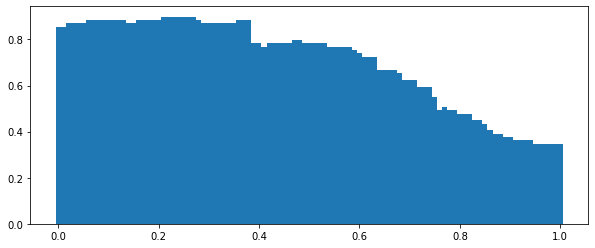

Maximum threshold: 0.21, with accuracy: 0.8985507246376812


In [121]:
# Optimise the outlier_scores on accuracy
outlier_scores = clusterer.outlier_scores_[[(i in keys) for i in vector_ids]]
true = [data[i] for i in vector_ids if i in keys]
acc_scores = {}
for thr in range(0,101):
    thr /= 100
    acc_scores[thr] = accuracy_score(
        true,
        [(s > thr) for s in outlier_scores]
    )

x,y = zip(*acc_scores.items())
plt.figure(figsize=(10,4))
plt.bar(x, y, width=.01)
plt.show()

print(f"Maximum threshold: {x[y.index(max(y))]}, with accuracy: {max(y)}")